# Акустические модели

Акустическая модель - это часть системы автоматического распознавания речи, которая используется для преобразования аудиосигнала речи в последовательность фонем или других единиц речевого звука. Акустическая модель обучается на большом наборе речевых данных, чтобы определить, какие звуки соответствуют конкретным акустическим признакам в аудиосигнале. Эта модель может использоваться вместе с другими компонентами, такими как языковая модель и модель декодирования, чтобы достичь более точного распознавания речи.

В данной работе мы сконцентрируемся на обучении нейросетевых акустических моделей с помощью библиотек torch и torchaudio. Для экспериментов будем использовать базу [TIMIT](https://catalog.ldc.upenn.edu/LDC93s1)

In [1]:
import numpy as np
import time
import torch
import os
from typing import List, Dict, Union, Set, Any
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
import soundfile as sf
import torchaudio
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


g:\Python3.9.5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загрузка датасета TIMIT

Официальная страница датасета TIMIT 

Для простоты загрузки данных удобнее всего пользоваться копией датасета, выложенной на kaggle 

https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech


In [2]:
#!pip install kaggle

In [3]:
# https://github.com/Kaggle/kaggle-api - Docs kaggle 
# Simplest way: go to https://www.kaggle.com/settings , "Create new token" and move it into "~/.kaggle"

!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech


  0%|          | 0.00/829M [00:00<?, ?B/s]
  0%|          | 1.00M/829M [00:00<08:23, 1.72MB/s]
  0%|          | 2.00M/829M [00:00<04:18, 3.35MB/s]
  0%|          | 4.00M/829M [00:00<02:23, 6.01MB/s]
  1%|          | 6.00M/829M [00:01<01:50, 7.80MB/s]
  1%|          | 8.00M/829M [00:01<01:35, 9.03MB/s]
  1%|          | 10.0M/829M [00:01<01:27, 9.86MB/s]
  1%|▏         | 12.0M/829M [00:01<01:21, 10.5MB/s]
  2%|▏         | 14.0M/829M [00:01<01:18, 10.9MB/s]
  2%|▏         | 16.0M/829M [00:01<01:16, 11.2MB/s]
  2%|▏         | 18.0M/829M [00:02<01:14, 11.3MB/s]
  2%|▏         | 20.0M/829M [00:02<01:13, 11.5MB/s]
  3%|▎         | 22.0M/829M [00:02<01:12, 11.6MB/s]
  3%|▎         | 24.0M/829M [00:02<01:12, 11.7MB/s]
  3%|▎         | 26.0M/829M [00:02<01:11, 11.7MB/s]
  3%|▎         | 28.0M/829M [00:03<01:12, 11.6MB/s]
  4%|▎         | 30.0M/829M [00:03<01:12, 11.6MB/s]
  4%|▍         | 32.0M/829M [00:03<01:11, 11.7MB/s]
  4%|▍         | 34.0M/829M [00:03<01:11, 11.7MB/s]
  4%|▍         | 36.

In [4]:
# !unzip -o -q darpa-timit-acousticphonetic-continuous-speech.zip -d timit/

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


# 1. Подготовка данных для обучения

TIMIT является одной из самых широко используемых баз данных для изучения систем автоматического распознавания речи. База данных TIMIT содержит произнесения предложений различными дикторами. Каждое произнесение сопровождается его словной и фонетической разметкой.

Для обучения акустической модели нам в первую очередь интересна фонетическая разметка произнесений. Такая разметка сопоставляет фонемы, которые были произнесены диктором, с временными интервалами в записи. Такая разметка позволит нам обучить пофреймовый классификатор, который будет предсказывать сказанную фонему.

## 1.a. Загрузка базы с диска

In [12]:
import re

for d, _, fs in os.walk('timit/data/TEST/'):
    print(re.sub(r'\\', '/', d), fs)

timit/data/TEST/ []
timit/data/TEST/DR1 []
timit/data/TEST/DR1/FAKS0 ['SA1.PHN', 'SA1.TXT', 'SA1.WAV', 'SA1.WAV.wav', 'SA1.WRD', 'SA2.PHN', 'SA2.TXT', 'SA2.WAV', 'SA2.WAV.wav', 'SA2.WRD', 'SI1573.PHN', 'SI1573.TXT', 'SI1573.WAV', 'SI1573.WAV.wav', 'SI1573.WRD', 'SI2203.PHN', 'SI2203.TXT', 'SI2203.WAV', 'SI2203.WAV.wav', 'SI2203.WRD', 'SI943.PHN', 'SI943.TXT', 'SI943.WAV', 'SI943.WAV.wav', 'SI943.WRD', 'SX133.PHN', 'SX133.TXT', 'SX133.WAV', 'SX133.WAV.wav', 'SX133.WRD', 'SX223.PHN', 'SX223.TXT', 'SX223.WAV', 'SX223.WAV.wav', 'SX223.WRD', 'SX313.PHN', 'SX313.TXT', 'SX313.WAV', 'SX313.WAV.wav', 'SX313.WRD', 'SX403.PHN', 'SX403.TXT', 'SX403.WAV', 'SX403.WAV.wav', 'SX403.WRD', 'SX43.PHN', 'SX43.TXT', 'SX43.WAV', 'SX43.WAV.wav', 'SX43.WRD']
timit/data/TEST/DR1/FDAC1 ['SA1.PHN', 'SA1.TXT', 'SA1.WAV', 'SA1.WAV.wav', 'SA1.WRD', 'SA2.PHN', 'SA2.TXT', 'SA2.WAV', 'SA2.WAV.wav', 'SA2.WRD', 'SI1474.PHN', 'SI1474.TXT', 'SI1474.WAV', 'SI1474.WAV.wav', 'SI1474.WRD', 'SI2104.PHN', 'SI2104.TXT', 'SI2104.

In [2]:
class TimitDataset(Dataset):
    """Загрузка TIMIT данных с диска"""
    def __init__(self, data_path):
        self.data_path = data_path
        self.uri2wav = {}
        self.uri2text = {}
        self.uri2word_ali = {}
        self.uri2phone_ali = {}
        for d, _, fs in os.walk(data_path):
            # d = re.sub(r'\\', '/', d)
            for f in fs:
                full_path = f'{d}/{f}'
                if f.endswith('.WAV'):
                    # skip it. Use .wav instead
                    pass
                elif f.endswith('.wav'):
                    stem = Path(f[:-4]).stem # .WAV.wav
                    self.uri2wav[f'{d}/{stem}'] = full_path
                elif f.endswith('.TXT'):
                    stem = Path(f).stem
                    self.uri2text[f'{d}/{stem}'] = full_path
                elif f.endswith('.WRD'):
                    stem = Path(f).stem
                    self.uri2word_ali[f'{d}/{stem}'] = full_path
                elif f.endswith('.PHN'):
                    stem = Path(f).stem
                    self.uri2phone_ali[f'{d}/{stem}'] = full_path
                else:
                    warnings.warn(f"Unknown file type {full_path} . Skip it.")
        
        self.uris = list(sorted(set(self.uri2wav.keys()) \
                                & set(self.uri2text.keys()) \
                                & set(self.uri2word_ali.keys()) \
                                &  set(self.uri2phone_ali.keys())
                               ))
        print(f"Found {len(self.uris)} utterances in {self.data_path}. ", 
              f"{len(self.uri2wav)} wavs, ", 
              f"{len(self.uri2text)} texts, ",
              f"{len(self.uri2word_ali)} word alinments, ",
             f"{len(self.uri2phone_ali)} phone alignments")
    
    def get_uri(self, index_or_uri: Union[str, int]):
        if isinstance(index_or_uri, str):
            uri = index_or_uri
        else:
            uri = self.uris[index_or_uri]
        return uri
    
    
    def get_audio(self, index_or_uri: Union[str, int]):
        uri = self.get_uri(index_or_uri)
        wav_path = self.uri2wav[uri]
        wav_channels, sr = torchaudio.load(wav_path)
        return wav_channels[0], sr 
        
    def get_text(self, index_or_uri: Union[str, int]):
        """ Return (start_sample, stop_sample, text)"""
        uri = self.get_uri(index_or_uri)
        txt_path = self.uri2text[uri]
        with open(txt_path) as f:
            start, stop, text = f.read().strip().split(maxsplit=2)
            start, stop = int(start), int(stop)
            assert start == 0, f"{txt_path}"
        return start, stop, text
    
    def get_word_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, word), ...]"""
        uri = self.get_uri(index_or_uri)
        wrd_path = self.uri2word_ali[uri]
        with open(wrd_path) as f:
            words = [(int(start), int(stop), word) for start, stop, word in map(str.split, f.readlines())]
        return words
    
    def get_phone_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, phone), ...]"""
        uri = self.get_uri(index_or_uri)
        ph_path = self.uri2phone_ali[uri]
        with open(ph_path) as f:
            phonemes = [(int(start), int(stop), ph) for start, stop, ph in map(str.split, f.readlines())]
        return phonemes
    
    def __getitem__(self, index):
        return {"uri": self.get_uri(index),
                "audio": self.get_audio(index),
                "text": self.get_text(index),
                "word_ali": self.get_word_ali(index),
                "phone_ali": self.get_phone_ali(index)}       

    def __len__(self):
        # TODO
        # верните количество элементов в выборке 
        return len(self.uris)

    def total_audio_samples(self) -> int:
        # верните суммарное количество отсчетов во всем аудио
        res = 0
        for wav_path in self.uri2wav:
            wav, sr = self.get_audio(wav_path)
            res += len(wav)

        return res

    def total_num_words(self) -> int:
        # верните суммарное количество слов в словном выравнивании
        return sum([len(open(word_path + '.WRD').readlines()) for word_path in self.uri2word_ali])

    
    def total_num_phones(self) -> int:
        # верните суммарное количество фонем в фонемном выравнивании
        return sum([len(open(word_path + '.PHN').readlines()) for word_path in self.uri2phone_ali])
    
    def get_vocab(self) -> Set[str]:
        # верните словарь, состоящий из уникальных слов из выборки 
        word_set = set()
        for word_path in self.uri2word_ali:
            word_set.update([word for start, stop, word in map(str.split, open(word_path + '.WRD').readlines())])
        return word_set

    def get_phones(self) -> Set[str]:
        # верните уникальный набор фонем, которые используются в выравнивании
        phone_set = set()
        for phone_path in self.uri2phone_ali:
            phone_set.update([phone for start, stop, phone in map(str.split, open(phone_path + '.PHN').readlines())])
        return phone_set

    def phones_prior(self) -> Dict[str, float]:
        # верните мапинг фонемы в их априорные вероятности. 
        all_cnt = 0
        phone_prior = {}
        for phone_path in self.uri2phone_ali:
            phonems = [phone for start, stop, phone in map(str.split, open(phone_path + '.PHN').readlines())]
            all_cnt += len(phonems)

            for phone in phonems:
                if phone in phone_prior:
                    phone_prior[phone] += 1
                else:
                    phone_prior[phone] = 1
                    
        for phone in phone_prior:
            phone_prior[phone] = phone_prior[phone] / all_cnt

        return phone_prior
        

In [3]:

def test_timit_dataset_stats():
    test_ds = TimitDataset('timit/data/TEST/')

    print("Len")
    assert len(test_ds) == 1680, f"{len(test_ds)}"

    print("Audio")
    audio_len = test_ds.total_audio_samples()
    assert audio_len == 82986452, f"{audio_len}"

    print("Words")
    words_len = test_ds.total_num_words()
    assert words_len == 14553, f"{words_len}"

    print("Phones")
    phones_len = test_ds.total_num_phones()
    assert phones_len == 64145, f"{phones_len}"

    print("Vocab")
    vocab = test_ds.get_vocab()
    assert len(set(vocab)) == 2378, f"{len(set(vocab))}"

    print("Phones vocab")
    phones = test_ds.get_phones()
    assert len(set(phones)) == 61, f"{len(set(phones))}"
    
    print("Phones prior")
    priors = test_ds.phones_prior()
    assert np.isclose(sum(priors.values()), 1.0), f"sum(priors.values())"
    pmin, pmax = min(priors.keys(), key=priors.get), max(priors.keys(), key=priors.get)
    assert pmin == 'eng', pmin
    assert pmax == 'h#', pmax
    print("Test 1.a passed")
test_timit_dataset_stats()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Len
Audio
Words
Phones
Vocab
Phones vocab
Phones prior
Test 1.a passed


In [4]:
test_ds = TimitDataset('timit/data/TEST/')
item = test_ds[5]
print(item['uri'])
print(item['text'][2])
display.display(display.Audio(item['audio'][0].numpy(), rate=item['audio'][1]))
print('---words---')
for start, stop, word in item['word_ali']:
    print(word)
    display.display(display.Audio(item['audio'][0][start:stop].numpy(), rate=item['audio'][1]))
    break

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
timit/data/TEST/DR1\FAKS0/SX133
Pizzerias are convenient for a quick lunch.


---words---
pizzerias


## 1.b. Экстрактор фич
Для того чтобы построить акустическую модель, первым делом надо извлечь признаки аудио сигнала. Для распознавания речь принято использовать fbank признаки. fbank/MelSpectrogram признаки получается из амплитудного спектра сигнала путем свертки спекта с треугольными фильтрами в мел-шкале. Есть множество реализаций данных признаков в различных библиотеках (kaldi, librosa, torchaudio) и все они имеют свои особенности. В данной работе мы будем использовать реализацию из библиотеки torchaudio. 

In [7]:
class FeatureExtractor(torch.nn.Module):
    def __init__(
        self,
        sample_rate=16000,
        n_fft=400,
        hop_length=160,
        n_mels=40,
        f_max=7600,
        spec_aug_max_fmask=80,
        spec_aug_max_tmask=80,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        #TODO
        # инициализируйте обработчик fbank фич из torchaudio
        self.mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, 
                                                             n_fft=self.n_fft,
                                                             hop_length=self.hop_length,
                                                             n_mels=self.n_mels)
        
        
    def samples2frames(self, num_samples: int) -> int:
        # TODO
        # Верните количество кадров в спектрограмме, соответствующей вавке длиной num_samples
        return num_samples // self.hop_length + 1
    
    @property
    def feats_dim(self):
        # TODO
        # Верните количество извлекаемых фич
        return self.n_mels
    
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        mel = self.mel_spec(waveform)
        return mel

In [8]:
def test_samples2frames():
    fe = FeatureExtractor()
    for i in tqdm(range(15000, 40000)):
        wav = torch.zeros(i)
        feats = fe(wav)
        assert feats.shape[-2] == fe.feats_dim, f"{i} {feats.shape[-2]=}, {fe.feats_dim}"

        assert feats.shape[-1] == fe.samples2frames(i), f"{i} {feats.shape[-1]=}, {fe.samples2frames(i)}"
        
    print('Test 1.b passed')
test_samples2frames()

100%|██████████| 25000/25000 [00:14<00:00, 1678.15it/s]

Test 1.b passed


## 1.с. Таргеты и объединение данных в батчи 

Акустическая Модель (АМ) - пофреймовый классификатор, который предсказывает фонему для каждого кадра аудио. Для обучения AM будем использовать фонемное выравнивание. 

In [9]:
train_ds = TimitDataset('timit/data/TRAIN/')
print(train_ds[0])

# Строим мапинг из написания фонемы в ее id 
phones = train_ds.get_phones() 
phones.remove('pau')
phones.remove('epi')
phones.remove('h#')

# Фонемы паузы должны иметь индекс 0
PHONE2ID = {p:i for i, p in enumerate(['pau'] + list(sorted(phones)))}
PHONE2ID['epi'] = 0
PHONE2ID['h#'] = 0
print(PHONE2ID)

Found 4620 utterances in timit/data/TRAIN/.  4620 wavs,  4620 texts,  4620 word alinments,  4620 phone alignments
{'uri': 'timit/data/TRAIN/DR1\\FCJF0/SA1', 'audio': (tensor([ 3.0518e-05, -3.0518e-05,  6.1035e-05,  ..., -3.0518e-05,
        -1.5259e-04, -2.4414e-04]), 16000), 'text': (0, 46797, 'She had your dark suit in greasy wash water all year.'), 'word_ali': [(3050, 5723, 'she'), (5723, 10337, 'had'), (9190, 11517, 'your'), (11517, 16334, 'dark'), (16334, 21199, 'suit'), (21199, 22560, 'in'), (22560, 28064, 'greasy'), (28064, 33360, 'wash'), (33754, 37556, 'water'), (37556, 40313, 'all'), (40313, 44586, 'year')], 'phone_ali': [(0, 3050, 'h#'), (3050, 4559, 'sh'), (4559, 5723, 'ix'), (5723, 6642, 'hv'), (6642, 8772, 'eh'), (8772, 9190, 'dcl'), (9190, 10337, 'jh'), (10337, 11517, 'ih'), (11517, 12500, 'dcl'), (12500, 12640, 'd'), (12640, 14714, 'ah'), (14714, 15870, 'kcl'), (15870, 16334, 'k'), (16334, 18088, 's'), (18088, 20417, 'ux'), (20417, 21199, 'q'), (21199, 22560, 'en'), (22

In [60]:
class FeatsPhoneDataset(TimitDataset):
    def __init__(self, data_path, feature_extractor: FeatureExtractor, phone2id):
        super().__init__(data_path)
        self.feature_extractor = feature_extractor
        self.phone2id = phone2id
    
    def __getitem__(self, index):
        orig_item = super().__getitem__(index)
        wav, sr = orig_item['audio']
        assert sr == self.feature_extractor.sample_rate, f"wrong sr for {index}"
        # подготавливаем пофреймовые фичи
        feats = self.feature_extractor(wav)
        feats = feats.squeeze(dim=0).transpose(0, 1) # time x feats

        # создаем пофреймовое выравнивание 
        targets = torch.zeros(feats.shape[0], dtype=torch.long)
        # заполните пофреймовое фонемное выравнивание targets idшниками фонем
        # используйте phone_ali 
        for l, r, phone in orig_item['phone_ali']:
            frames_before_l = self.feature_extractor.samples2frames(l)
            frames_before_r = self.feature_extractor.samples2frames(r)
            targets[frames_before_l: frames_before_r] = self.phone2id[phone]
        
        return {"uri": orig_item["uri"],
                "feats": feats,
                "targets": targets, 
                "src_key_padding_mask": torch.zeros(feats.shape[0], dtype=torch.bool)}
    
    def collate_pad(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Функция объединения элементов в один батч"""
        # TODO 
        # Реализуйте функцию, которая объединяет несколько item'ов датасета в один батч
        # See collate_fn https://pytorch.org/docs/stable/data.html
        # Входные данные и маску надо вернуть таком формате, в каком работает с данными torch.nn.Transformer
        # targets надо склеить тензор с одной осью. Длина оси будет равна суммарному количеству кадров в батче
        feats = nn.utils.rnn.pad_sequence([i['feats'] for i in batch], batch_first=True).transpose(0, 1)
        targets = torch.cat([i['targets'] for i in batch])
        src_key_padding_mask = []
        for item in batch:
            data_len = item['feats'].shape[0]
            src_key_padding_mask.append(np.arange(feats.shape[0]) >= data_len)
        src_key_padding_mask = torch.BoolTensor(src_key_padding_mask)

        return {'feats': feats, # (Time, Batch, feats)
               'targets': targets, #(SumTime)
               'src_key_padding_mask': src_key_padding_mask, #(Batch, Time)
               }
        

In [61]:
def test_collate_pad():
    fe = FeatureExtractor()
    test_ds = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)

    for i in range(20):
        targets = test_ds[i]['targets']
        orig_ph_ali = test_ds.get_phone_ali(i)
        targets_set = set(targets.tolist())
        orig_set = set([PHONE2ID[ph] for *_, ph in orig_ph_ali])
        assert targets_set == orig_set, f"{i} \n{targets_set} \n {orig_set} \n {orig_ph_ali}"

    items = [test_ds[i] for i in range(30)]
    batch = test_ds.collate_pad(items)
    assert len(batch['feats'].shape) == 3, batch['feats'].shape
    assert batch['feats'].shape[1] == 30, batch['feats'].shape
    
    assert len(batch['src_key_padding_mask'].shape) == 2, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[0] == 30, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[1] == batch['feats'].shape[0], f"{batch['feats'].shape} {batch['src_key_padding_mask'].shape}"
    
    number_nonmasked_frames = (~batch['src_key_padding_mask']).sum()
    assert number_nonmasked_frames == len(batch['targets']), f"{number_nonmasked_frames} != {len(batch['targets'])}"

    accumulated_len = 0
    for i, item in enumerate(items):
        feats = batch['feats'][:, i, :]
        assert torch.isclose(feats.sum(), item['feats'].sum()) , i
        src = batch['src_key_padding_mask'][i, :]
        cutted_feats = feats[~src]
        assert torch.isclose(item['feats'], cutted_feats).all()
        cutted_targets = batch['targets'][accumulated_len: accumulated_len + cutted_feats.shape[0]]
        assert torch.isclose(cutted_targets, item['targets']).all()
        accumulated_len += cutted_feats.shape[0]
    print("Test 1.c passed")
    
test_collate_pad()


Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Test 1.c passed


C:\Users\gena\AppData\Local\Temp\ipykernel_9564\253412054.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  src_key_padding_mask = torch.BoolTensor(src_key_padding_mask)


# 2. Акустическая модель

Обучим TransformerEncoder из torch решать задачу пофреймовой классификации. 

In [62]:
class AModel(nn.Module):
    def __init__(self, feats_dim, out_dim,  dim=128, num_layers=4, ff_dim=256, dropout=0.1, nhead=4, max_len=780):
        super().__init__()
        self.feats_dim = feats_dim
        self.max_len=max_len
        self.input_ff = nn.Linear(feats_dim, dim)
        self.positional_encoding = nn.Embedding(max_len, dim)
        layer = torch.nn.TransformerEncoderLayer(d_model=dim, 
                                                 nhead=nhead, 
                                                 dim_feedforward=ff_dim, 
                                                 dropout=dropout, 
                                                 batch_first=False)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=layer, num_layers=num_layers)
        
        self.head = nn.Linear(dim, out_dim)

    def forward(self, feats, src_key_padding_mask=None, **kwargs):
        #TODO 
        # реализуйте прямой проход модели.
        # Фичи подаются на первый ff слой, 
        # к результату прибавляются позиционные эмбединги.
        # Далее фреймы обрабатываются трансформером 
        # и финализируются с помощью головы
        x = self.input_ff(feats)
        x += self.positional_encoding(torch.arange(0, feats.size(0), device=feats.device).unsqueeze(1))
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = self.head(x)

        return x

## 3. Обучение модели 

In [63]:
# Стандартный пайплайн обучения моделей в pytorch
class Trainer(nn.Module):
    def __init__(self, model, fe, phone2id, device='cuda', opt_cls=torch.optim.Adam, opt_kwargs={'lr':0.0001}):
        super().__init__()
        self.device=device
        self.fe = fe
        self.model = model.to(self.device)
        self.phone2id = phone2id
        self.id2phone = {i:ph for ph,i in phone2id.items()}
        self.optimizer = opt_cls(self.model.parameters(), **opt_kwargs)
        self.criterion = torch.nn.CrossEntropyLoss()
        print(f"{self.model}. {self.device}")

    def to(self, device):
        self.device = device
        return super().to()
        
    def forward(self, batch):
        batch = self.batch_to_device(batch)
        logits = self.model(**batch)
        # TODO
        # реализуйте подсчет loss функции  
        reverse_mask = ~batch['src_key_padding_mask']
        reshaped_logits = logits.permute(1, 0 , 2)
        
        return self.criterion(reshaped_logits[reverse_mask], batch['targets'])

    def batch_to_device(self, batch):
        return {k: v.to(self.device) for k, v in batch.items()}
        
    def train_one_epoch(self, train_dataloader):
        """ Цикл обучения одной эпохи по всем данным"""
        self.model.train()
        pbar = tqdm(train_dataloader)
        losses = []
        for batch in pbar:
            self.optimizer.zero_grad()
            loss = self.forward(batch)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            pbar.set_description(f"training loss {losses[-1]:.5f}")
        return losses

    def score(self, valid_dataloader) -> List[float]:
        """Подсчет лосса на валидационной выборке"""
        pbar = tqdm(valid_dataloader, desc="Scoring...")
        losses = []
        # TODO 
        # реализуйте функцию, которая подсчитывает лосс на валидационной выборке 
        # losses должен хранить значение ошибки на каждом батче 
        self.model.eval()
        for batch in pbar:
            with torch.no_grad():
                losses.append(self.forward(batch).item())
        
        return losses

    def fit(self, train_dataloader, epochs, valid_dataloader=None, plot_losses=True):
        """Запуск обучения на данном dataloader"""
        pbar = tqdm(range(epochs))
        per_epoch_train_losses = []
        per_epoch_val_losses = []
        for e in pbar:
            train_loss = np.mean(self.train_one_epoch(train_dataloader))
            per_epoch_train_losses.append(train_loss)
            if valid_dataloader is not None:
                val_loss = np.mean(self.score(valid_dataloader))
                per_epoch_val_losses.append(val_loss)
            if plot_losses:
                display.clear_output()
                self.plot_losses(per_epoch_train_losses, per_epoch_val_losses)
            else:
                val_loss = val_loss if valid_dataloader is not None else float('Nan')
                print(f"train: {train_loss:.5f} | val: {val_loss:.5f}")
        return per_epoch_train_losses, per_epoch_val_losses
    
    def plot_losses(self, train_losses, val_losses=[]):
        plt.title(f"Train test losses (epoch {len(train_losses)})")
        plt.plot(range(len(train_losses)), train_losses)
        if len(val_losses)>0:
            assert len(train_losses) == len(val_losses)
            plt.plot(range(len(val_losses)), val_losses)
        plt.ylabel("loss")
        plt.xlabel('epoch')
        plt.legend(["train loss", "valid loss"])
        plt.grid(True)
        plt.show()
                 
            
                

Found 10 utterances in timit/data/TEST/DR1/FAKS0.  10 wavs,  10 texts,  10 word alinments,  10 phone alignments
AModel(
  (input_ff): Linear(in_features=40, out_features=256, bias=True)
  (positional_encoding): Embedding(780, 256)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=256, out_features=59, bias=True)
).

  0%|          | 0/160 [00:00<?, ?it/s]C:\Users\gena\AppData\Local\Temp\ipykernel_9564\253412054.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  src_key_padding_mask = torch.BoolTensor(src_key_padding_mask)
  1%|          | 1/160 [00:00<02:05,  1.27it/s]

train: 4.10163 | val: 3.85576


  1%|▏         | 2/160 [00:01<01:50,  1.43it/s]

train: 3.84555 | val: 3.70291


  2%|▏         | 3/160 [00:02<01:45,  1.49it/s]

train: 3.69093 | val: 3.62240


  2%|▎         | 4/160 [00:02<01:42,  1.52it/s]

train: 3.61024 | val: 3.56190


  3%|▎         | 5/160 [00:03<01:40,  1.55it/s]

train: 3.55083 | val: 3.50458


  4%|▍         | 6/160 [00:03<01:38,  1.56it/s]

train: 3.49496 | val: 3.45832


  4%|▍         | 7/160 [00:04<01:39,  1.54it/s]

train: 3.45003 | val: 3.42560


  5%|▌         | 8/160 [00:05<01:37,  1.56it/s]

train: 3.41835 | val: 3.39885


  6%|▌         | 9/160 [00:05<01:36,  1.57it/s]

train: 3.39231 | val: 3.37220


  6%|▋         | 10/160 [00:06<01:35,  1.57it/s]

train: 3.36614 | val: 3.34541


  7%|▋         | 11/160 [00:07<01:34,  1.58it/s]

train: 3.33964 | val: 3.32092


  8%|▊         | 12/160 [00:07<01:33,  1.58it/s]

train: 3.31528 | val: 3.30010


  8%|▊         | 13/160 [00:08<01:32,  1.58it/s]

train: 3.29450 | val: 3.28166


  9%|▉         | 14/160 [00:09<01:32,  1.58it/s]

train: 3.27607 | val: 3.26269


  9%|▉         | 15/160 [00:09<01:32,  1.57it/s]

train: 3.25714 | val: 3.24106


 10%|█         | 16/160 [00:10<01:31,  1.57it/s]

train: 3.23568 | val: 3.21709


 11%|█         | 17/160 [00:10<01:30,  1.58it/s]

train: 3.21202 | val: 3.19250


 11%|█▏        | 18/160 [00:11<01:29,  1.58it/s]

train: 3.18788 | val: 3.16852


 12%|█▏        | 19/160 [00:12<01:28,  1.59it/s]

train: 3.16442 | val: 3.14453


 12%|█▎        | 20/160 [00:12<01:28,  1.59it/s]

train: 3.14100 | val: 3.11915


 13%|█▎        | 21/160 [00:13<01:27,  1.59it/s]

train: 3.11617 | val: 3.09187


 14%|█▍        | 22/160 [00:14<01:26,  1.59it/s]

train: 3.08942 | val: 3.06359


 14%|█▍        | 23/160 [00:14<01:25,  1.60it/s]

train: 3.06165 | val: 3.03546


 15%|█▌        | 24/160 [00:15<01:25,  1.59it/s]

train: 3.03403 | val: 3.00742


 16%|█▌        | 25/160 [00:15<01:25,  1.59it/s]

train: 3.00653 | val: 2.97862


 16%|█▋        | 26/160 [00:16<01:24,  1.59it/s]

train: 2.97828 | val: 2.94870


 17%|█▋        | 27/160 [00:17<01:23,  1.59it/s]

train: 2.94884 | val: 2.91836


 18%|█▊        | 28/160 [00:17<01:22,  1.59it/s]

train: 2.91878 | val: 2.88807


 18%|█▊        | 29/160 [00:18<01:22,  1.59it/s]

train: 2.88856 | val: 2.85778


 19%|█▉        | 30/160 [00:19<01:21,  1.59it/s]

train: 2.85818 | val: 2.82718


 19%|█▉        | 31/160 [00:19<01:20,  1.60it/s]

train: 2.82746 | val: 2.79641


 20%|██        | 32/160 [00:20<01:19,  1.60it/s]

train: 2.79658 | val: 2.76571


 21%|██        | 33/160 [00:20<01:19,  1.60it/s]

train: 2.76584 | val: 2.73507


 21%|██▏       | 34/160 [00:21<01:18,  1.61it/s]

train: 2.73524 | val: 2.70445


 22%|██▏       | 35/160 [00:22<01:17,  1.61it/s]

train: 2.70471 | val: 2.67401


 22%|██▎       | 36/160 [00:22<01:16,  1.61it/s]

train: 2.67435 | val: 2.64376


 23%|██▎       | 37/160 [00:23<01:16,  1.61it/s]

train: 2.64415 | val: 2.61328


 24%|██▍       | 38/160 [00:24<01:16,  1.60it/s]

train: 2.61368 | val: 2.58216


 24%|██▍       | 39/160 [00:24<01:15,  1.60it/s]

train: 2.58258 | val: 2.55073


 25%|██▌       | 40/160 [00:25<01:14,  1.60it/s]

train: 2.55119 | val: 2.51971


 26%|██▌       | 41/160 [00:25<01:14,  1.61it/s]

train: 2.52029 | val: 2.48917


 26%|██▋       | 42/160 [00:26<01:13,  1.61it/s]

train: 2.48992 | val: 2.45894


 27%|██▋       | 43/160 [00:27<01:12,  1.61it/s]

train: 2.45987 | val: 2.42899


 28%|██▊       | 44/160 [00:27<01:12,  1.60it/s]

train: 2.43014 | val: 2.39906


 28%|██▊       | 45/160 [00:28<01:11,  1.60it/s]

train: 2.40048 | val: 2.36898


 29%|██▉       | 46/160 [00:29<01:11,  1.60it/s]

train: 2.37068 | val: 2.33893


 29%|██▉       | 47/160 [00:29<01:10,  1.60it/s]

train: 2.34086 | val: 2.30899


 30%|███       | 48/160 [00:30<01:09,  1.60it/s]

train: 2.31111 | val: 2.27949


 31%|███       | 49/160 [00:30<01:09,  1.60it/s]

train: 2.28179 | val: 2.25053


 31%|███▏      | 50/160 [00:31<01:08,  1.60it/s]

train: 2.25304 | val: 2.22194


 32%|███▏      | 51/160 [00:32<01:07,  1.60it/s]

train: 2.22465 | val: 2.19364


 32%|███▎      | 52/160 [00:32<01:08,  1.57it/s]

train: 2.19650 | val: 2.16556


 33%|███▎      | 53/160 [00:33<01:07,  1.58it/s]

train: 2.16854 | val: 2.13784


 34%|███▍      | 54/160 [00:34<01:06,  1.58it/s]

train: 2.14092 | val: 2.11058


 34%|███▍      | 55/160 [00:34<01:06,  1.59it/s]

train: 2.11374 | val: 2.08359


 35%|███▌      | 56/160 [00:35<01:05,  1.59it/s]

train: 2.08679 | val: 2.05694


 36%|███▌      | 57/160 [00:35<01:04,  1.60it/s]

train: 2.06017 | val: 2.03052


 36%|███▋      | 58/160 [00:36<01:03,  1.60it/s]

train: 2.03378 | val: 2.00420


 37%|███▋      | 59/160 [00:37<01:03,  1.60it/s]

train: 2.00751 | val: 1.97801


 38%|███▊      | 60/160 [00:37<01:02,  1.60it/s]

train: 1.98137 | val: 1.95200


 38%|███▊      | 61/160 [00:38<01:01,  1.61it/s]

train: 1.95540 | val: 1.92628


 39%|███▉      | 62/160 [00:39<01:00,  1.61it/s]

train: 1.92972 | val: 1.90089


 39%|███▉      | 63/160 [00:39<01:00,  1.61it/s]

train: 1.90437 | val: 1.87568


 40%|████      | 64/160 [00:40<00:59,  1.61it/s]

train: 1.87921 | val: 1.85068


 41%|████      | 65/160 [00:40<00:59,  1.61it/s]

train: 1.85426 | val: 1.82586


 41%|████▏     | 66/160 [00:41<00:58,  1.61it/s]

train: 1.82948 | val: 1.80123


 42%|████▏     | 67/160 [00:42<00:57,  1.61it/s]

train: 1.80489 | val: 1.77678


 42%|████▎     | 68/160 [00:42<00:57,  1.61it/s]

train: 1.78050 | val: 1.75252


 43%|████▎     | 69/160 [00:43<00:56,  1.61it/s]

train: 1.75629 | val: 1.72852


 44%|████▍     | 70/160 [00:44<00:55,  1.61it/s]

train: 1.73233 | val: 1.70484


 44%|████▍     | 71/160 [00:44<00:55,  1.61it/s]

train: 1.70868 | val: 1.68136


 45%|████▌     | 72/160 [00:45<00:54,  1.61it/s]

train: 1.68524 | val: 1.65804


 46%|████▌     | 73/160 [00:45<00:54,  1.61it/s]

train: 1.66193 | val: 1.63486


 46%|████▋     | 74/160 [00:46<00:53,  1.61it/s]

train: 1.63875 | val: 1.61189


 47%|████▋     | 75/160 [00:47<00:52,  1.61it/s]

train: 1.61578 | val: 1.58925


 48%|████▊     | 76/160 [00:47<00:52,  1.61it/s]

train: 1.59313 | val: 1.56684


 48%|████▊     | 77/160 [00:48<00:51,  1.61it/s]

train: 1.57070 | val: 1.54463


 49%|████▉     | 78/160 [00:49<00:51,  1.61it/s]

train: 1.54846 | val: 1.52260


 49%|████▉     | 79/160 [00:49<00:50,  1.60it/s]

train: 1.52640 | val: 1.50072


 50%|█████     | 80/160 [00:50<00:49,  1.60it/s]

train: 1.50447 | val: 1.47896


 51%|█████     | 81/160 [00:50<00:49,  1.60it/s]

train: 1.48266 | val: 1.45735


 51%|█████▏    | 82/160 [00:51<00:48,  1.60it/s]

train: 1.46101 | val: 1.43587


 52%|█████▏    | 83/160 [00:52<00:48,  1.60it/s]

train: 1.43948 | val: 1.41451


 52%|█████▎    | 84/160 [00:52<00:47,  1.61it/s]

train: 1.41808 | val: 1.39324


 53%|█████▎    | 85/160 [00:53<00:46,  1.61it/s]

train: 1.39677 | val: 1.37206


 54%|█████▍    | 86/160 [00:54<00:46,  1.60it/s]

train: 1.37553 | val: 1.35099


 54%|█████▍    | 87/160 [00:54<00:45,  1.60it/s]

train: 1.35437 | val: 1.33005


 55%|█████▌    | 88/160 [00:55<00:45,  1.59it/s]

train: 1.33334 | val: 1.30924


 56%|█████▌    | 89/160 [00:55<00:44,  1.60it/s]

train: 1.31245 | val: 1.28856


 56%|█████▋    | 90/160 [00:56<00:44,  1.59it/s]

train: 1.29170 | val: 1.26799


 57%|█████▋    | 91/160 [00:57<00:43,  1.58it/s]

train: 1.27107 | val: 1.24755


 57%|█████▊    | 92/160 [00:57<00:43,  1.58it/s]

train: 1.25058 | val: 1.22726


 58%|█████▊    | 93/160 [00:58<00:42,  1.58it/s]

train: 1.23023 | val: 1.20712


 59%|█████▉    | 94/160 [00:59<00:41,  1.58it/s]

train: 1.21003 | val: 1.18712


 59%|█████▉    | 95/160 [00:59<00:41,  1.57it/s]

train: 1.18996 | val: 1.16723


 60%|██████    | 96/160 [01:00<00:40,  1.57it/s]

train: 1.16998 | val: 1.14742


 61%|██████    | 97/160 [01:00<00:39,  1.58it/s]

train: 1.15007 | val: 1.12774


 61%|██████▏   | 98/160 [01:01<00:39,  1.58it/s]

train: 1.13028 | val: 1.10820


 62%|██████▏   | 99/160 [01:02<00:38,  1.57it/s]

train: 1.11061 | val: 1.08882


 62%|██████▎   | 100/160 [01:02<00:38,  1.57it/s]

train: 1.09111 | val: 1.06964


 63%|██████▎   | 101/160 [01:03<00:37,  1.56it/s]

train: 1.07181 | val: 1.05078


 64%|██████▍   | 102/160 [01:04<00:37,  1.56it/s]

train: 1.05287 | val: 1.03264


 64%|██████▍   | 103/160 [01:04<00:36,  1.57it/s]

train: 1.03468 | val: 1.01603


 65%|██████▌   | 104/160 [01:05<00:35,  1.57it/s]

train: 1.01807 | val: 0.99998


 66%|██████▌   | 105/160 [01:06<00:35,  1.57it/s]

train: 1.00205 | val: 0.98054


 66%|██████▋   | 106/160 [01:06<00:34,  1.57it/s]

train: 0.98245 | val: 0.95887


 67%|██████▋   | 107/160 [01:07<00:33,  1.57it/s]

train: 0.96061 | val: 0.94340


 68%|██████▊   | 108/160 [01:08<00:32,  1.58it/s]

train: 0.94514 | val: 0.92790


 68%|██████▊   | 109/160 [01:08<00:32,  1.58it/s]

train: 0.92961 | val: 0.90716


 69%|██████▉   | 110/160 [01:09<00:31,  1.58it/s]

train: 0.90877 | val: 0.89086


 69%|██████▉   | 111/160 [01:09<00:30,  1.58it/s]

train: 0.89243 | val: 0.87574


 70%|███████   | 112/160 [01:10<00:30,  1.58it/s]

train: 0.87731 | val: 0.85625


 71%|███████   | 113/160 [01:11<00:29,  1.58it/s]

train: 0.85769 | val: 0.84016


 71%|███████▏  | 114/160 [01:11<00:29,  1.58it/s]

train: 0.84156 | val: 0.82504


 72%|███████▏  | 115/160 [01:12<00:28,  1.58it/s]

train: 0.82640 | val: 0.80652


 72%|███████▎  | 116/160 [01:13<00:27,  1.58it/s]

train: 0.80771 | val: 0.79079


 73%|███████▎  | 117/160 [01:13<00:27,  1.58it/s]

train: 0.79195 | val: 0.77577


 74%|███████▍  | 118/160 [01:14<00:26,  1.58it/s]

train: 0.77686 | val: 0.75813


 74%|███████▍  | 119/160 [01:14<00:25,  1.58it/s]

train: 0.75908 | val: 0.74254


 75%|███████▌  | 120/160 [01:15<00:25,  1.58it/s]

train: 0.74345 | val: 0.72788


 76%|███████▌  | 121/160 [01:16<00:24,  1.58it/s]

train: 0.72874 | val: 0.71114


 76%|███████▋  | 122/160 [01:16<00:24,  1.58it/s]

train: 0.71189 | val: 0.69552


 77%|███████▋  | 123/160 [01:17<00:23,  1.58it/s]

train: 0.69620 | val: 0.68112


 78%|███████▊  | 124/160 [01:18<00:22,  1.58it/s]

train: 0.68177 | val: 0.66551


 78%|███████▊  | 125/160 [01:18<00:22,  1.58it/s]

train: 0.66608 | val: 0.64983


 79%|███████▉  | 126/160 [01:19<00:21,  1.57it/s]

train: 0.65029 | val: 0.63527


 79%|███████▉  | 127/160 [01:20<00:21,  1.57it/s]

train: 0.63568 | val: 0.62085


 80%|████████  | 128/160 [01:20<00:20,  1.57it/s]

train: 0.62119 | val: 0.60606


 81%|████████  | 129/160 [01:21<00:19,  1.57it/s]

train: 0.60633 | val: 0.59143


 81%|████████▏ | 130/160 [01:21<00:18,  1.58it/s]

train: 0.59166 | val: 0.57838


 82%|████████▏ | 131/160 [01:22<00:18,  1.58it/s]

train: 0.57870 | val: 0.56736


 82%|████████▎ | 132/160 [01:23<00:17,  1.58it/s]

train: 0.56794 | val: 0.55691


 83%|████████▎ | 133/160 [01:23<00:17,  1.56it/s]

train: 0.55773 | val: 0.54213


 84%|████████▍ | 134/160 [01:24<00:16,  1.56it/s]

train: 0.54249 | val: 0.52627


 84%|████████▍ | 135/160 [01:25<00:15,  1.56it/s]

train: 0.52640 | val: 0.51329


 85%|████████▌ | 136/160 [01:25<00:15,  1.56it/s]

train: 0.51355 | val: 0.50197


 86%|████████▌ | 137/160 [01:26<00:14,  1.57it/s]

train: 0.50219 | val: 0.48937


 86%|████████▋ | 138/160 [01:27<00:14,  1.57it/s]

train: 0.48949 | val: 0.47655


 87%|████████▋ | 139/160 [01:27<00:13,  1.57it/s]

train: 0.47671 | val: 0.46492


 88%|████████▊ | 140/160 [01:28<00:12,  1.57it/s]

train: 0.46500 | val: 0.45262


 88%|████████▊ | 141/160 [01:28<00:12,  1.57it/s]

train: 0.45260 | val: 0.44114


 89%|████████▉ | 142/160 [01:29<00:11,  1.57it/s]

train: 0.44115 | val: 0.43061


 89%|████████▉ | 143/160 [01:30<00:10,  1.58it/s]

train: 0.43043 | val: 0.41922


 90%|█████████ | 144/160 [01:30<00:10,  1.58it/s]

train: 0.41911 | val: 0.40770


 91%|█████████ | 145/160 [01:31<00:09,  1.57it/s]

train: 0.40761 | val: 0.39740


 91%|█████████▏| 146/160 [01:32<00:08,  1.56it/s]

train: 0.39724 | val: 0.38740


 92%|█████████▏| 147/160 [01:32<00:08,  1.55it/s]

train: 0.38731 | val: 0.37633


 92%|█████████▎| 148/160 [01:33<00:07,  1.55it/s]

train: 0.37620 | val: 0.36750


 93%|█████████▎| 149/160 [01:34<00:07,  1.55it/s]

train: 0.36736 | val: 0.35808


 94%|█████████▍| 150/160 [01:34<00:06,  1.55it/s]

train: 0.35790 | val: 0.34808


 94%|█████████▍| 151/160 [01:35<00:05,  1.54it/s]

train: 0.34787 | val: 0.34005


 95%|█████████▌| 152/160 [01:36<00:05,  1.54it/s]

train: 0.33991 | val: 0.33009


 96%|█████████▌| 153/160 [01:36<00:04,  1.55it/s]

train: 0.32986 | val: 0.32105


 96%|█████████▋| 154/160 [01:37<00:03,  1.55it/s]

train: 0.32079 | val: 0.31303


 97%|█████████▋| 155/160 [01:37<00:03,  1.56it/s]

train: 0.31287 | val: 0.30370


 98%|█████████▊| 156/160 [01:38<00:02,  1.56it/s]

train: 0.30355 | val: 0.29597


 98%|█████████▊| 157/160 [01:39<00:01,  1.56it/s]

train: 0.29575 | val: 0.28856


 99%|█████████▉| 158/160 [01:39<00:01,  1.55it/s]

train: 0.28831 | val: 0.27998


 99%|█████████▉| 159/160 [01:40<00:00,  1.55it/s]

train: 0.27974 | val: 0.27411


100%|██████████| 160/160 [01:41<00:00,  1.58it/s]


train: 0.27387 | val: 0.26647


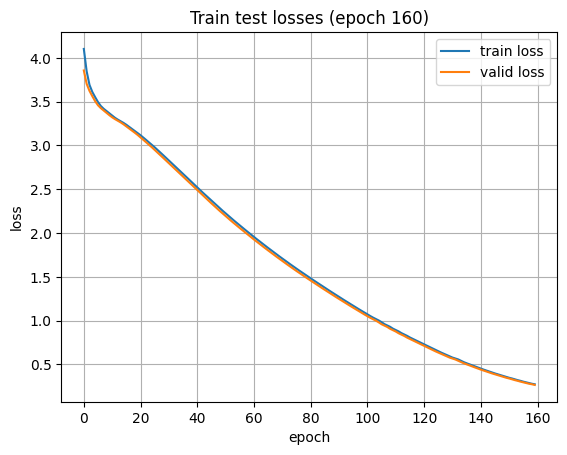

Scoring...: 100%|██████████| 10/10 [00:00<00:00, 40.64it/s]

Test 3.a passed


In [64]:
def overfit_one_batch_check():
    # Для проверки работоспособности кода обучения удоно использовать тест модели на overfit 
    # Для этого запускается обучение на одном батче данных. 
    # Если код написан правильно, то модель обязана выучить выучить все примеры из этого батча наизусть. 
    fe = FeatureExtractor()
    train_dataset = FeatsPhoneDataset('timit/data/TEST/DR1/FAKS0', feature_extractor=fe, phone2id=PHONE2ID)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_pad)
    test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=train_dataset.collate_pad)

    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim, 
                                   out_dim=max(PHONE2ID.values()) + 1,  
                                   dim=256, 
                                   num_layers=6, 
                                   ff_dim=512, 
                                   dropout=0.0, 
                                   nhead=8), 
                      fe=fe, 
                      phone2id=PHONE2ID, device='cuda')
   
    # only one batch. The model must learn it by heart
    losses, val_losses = trainer.fit(train_dataloader, 160, valid_dataloader=test_dataloader, plot_losses=False)

    trainer.plot_losses(losses, val_losses)

    val_loss = np.mean(trainer.score(test_dataloader))
    
    assert val_loss < 0.5, f"{val_loss}. Model doesn't train well" 
    print(f"Test 3.a passed")
overfit_one_batch_check()

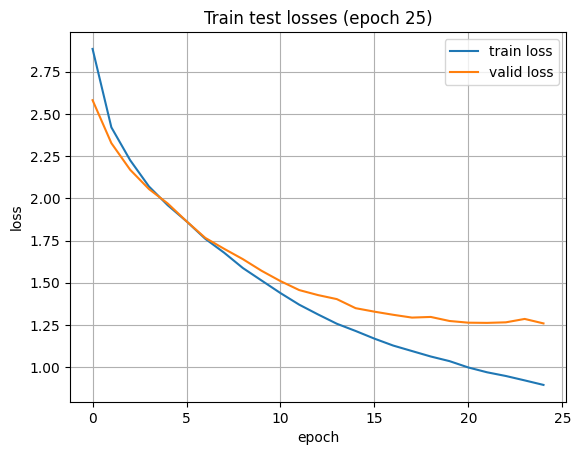

100%|██████████| 25/25 [24:32<00:00, 58.89s/it]


In [72]:

def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, 
                                               num_workers=0, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)


    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim, 
                                 out_dim=max(PHONE2ID.values())+1, 
                                 dim=128, 
                                 num_layers=7, 
                                 ff_dim=256, 
                                 dropout=0.0, 
                                 nhead=8),
                     fe=fe, 
                     phone2id=PHONE2ID, device='cuda',
                     opt_cls=torch.optim.AdamW,
                                 opt_kwargs={'lr': 0.0008})

    trainer.fit(train_dataloader, epochs=25, valid_dataloader=test_dataloader, plot_losses=True)
    return trainer.to('cpu')
results = experiment()

In [73]:
torch.save(results, 'baseline.trainer')

# Основное задание (12 баллов)
Надо улучшить бейзлайн так, чтобы значение loss на валидации было менее 1.9 

**Дополнительное задание** (4 балла): Улучшите loss до 1.4 

In [74]:
def test_trained_model(trainer):
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=trainer.fe, phone2id=trainer.phone2id)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)
    loss = np.mean(trainer.score(test_dataloader))
    print(f"Test loss is {loss}")
    assert loss < 1.9, "Main task failed"
    print(f"Main task is done! (12 points)")
    if loss <= 1.4:
        print(f"Additional task is done! (+4 points)")
test_trained_model(results.to('cuda'))

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments


Scoring...:   0%|          | 0/1680 [00:00<?, ?it/s]C:\Users\gena\AppData\Local\Temp\ipykernel_9564\253412054.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  src_key_padding_mask = torch.BoolTensor(src_key_padding_mask)
Scoring...: 100%|██████████| 1680/1680 [00:13<00:00, 126.13it/s]

Test loss is 1.2593079664256601
Main task is done! (12 points)
Additional task is done! (+4 points)
